# 2.05: Blood Glucose Analysis
This notebook is used to analyse the blood glucose data from the patients. The intention is to understand blood glucose patterns and how they relate to changes in the insulin on board (IOB) and carbohydrates on board (COB). The analysis will focus on the following:
1. **Variability**: How much the blood glucose levels vary between nights, between individuals and for an individual.
2. **Rate of Change**: How quickly the blood glucose levels change over time.
3. **Peaks**: How often the blood glucose levels peak above a certain threshold for certain periods of the night.
4. **Correlation**: How the blood glucose levels correlate with the IOB and COB levels.
Lets start by loading the data and extracting aggregated data around variability for individuals.

In [200]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from src.configurations import Configuration
from src.data_processing.read_preprocessed_df import ReadPreprocessedDataFrame
from src.data_processing.read import read_profile_offsets_csv
from src.helper import separate_flat_file, calculate_skew_kurtosis
from src.candidate_selection import remove_null_variable_individuals, \
    get_all_individuals_night_stats
from datetime import time
from src.data_processing.read_preprocessed_df import apply_and_filter_by_offsets
from src.time_series_analysis import return_count_intervals
from src.configurations import ThirtyMinute
from src.nights import Nights
from src.bg_analysis import BGAnalyser


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
config = Configuration()

df_new_30 = ReadPreprocessedDataFrame(ThirtyMinute(), file_type='parquet').df
df_offsets = read_profile_offsets_csv(config)
night_start = time(17, 0)
morning_end = time(11, 0)
sample_rate = 30
count_of_intervals = return_count_intervals(night_start, morning_end, minute_interval=sample_rate)
df_processed = apply_and_filter_by_offsets(offsets_df=df_offsets,
                                           interim_df=df_new_30,
                                           verbose=False)
df_processed = remove_null_variable_individuals(df_processed)
separated = separate_flat_file(df_processed)
df_overall_stats = get_all_individuals_night_stats(separated, sample_rate=sample_rate, night_start=night_start, morning_end=morning_end)


2025-06-27 15:26:05.226 | INFO     | src.candidate_selection:remove_null_variable_individuals:32 - Following individuals have one or more variables missing: set()
No stats per night have been calculated for 67167655. Returning no output.


The following analysis is based on the constraint (at the point of analysis) that we're putting on 'usable' nights which is that they have only a single 30min interval missing, or are complete, and a candidate must have 30 nights or greater. If these constraints change, then the analysis will only serve to show the process.

In [202]:
df_overall_stats['useful_nights'] = df_overall_stats['complete_nights'] + df_overall_stats['single_interval_nights']
df_stats = df_overall_stats[['count_of_nights', 'useful_nights', 'bg_sd_median', 'bg_range_median', 'bg_iqr_median']]
df_stats = df_stats[df_stats['useful_nights'] >= 30]
print(f'Total number of individuals with 30 or more useful nights: {len(df_stats)}')
print(f'Total number of nights across these individuals: {df_stats["useful_nights"].sum()}')

candidates = df_stats.index.tolist()

Total number of individuals with 30 or more useful nights: 17
Total number of nights across these individuals: 965


We'll now look at the variability of the blood glucose levels across the nights for each individual. The variability is measured by the standard deviation, range and interquartile range (IQR) of the blood glucose levels. This is across all 'useful' nights, i.e. defined as either complete nights or nights with a single 30min interval missing. The median of these values is used to represent the variability for each individual. The median is used to reduce the impact of outliers on the variability measure.

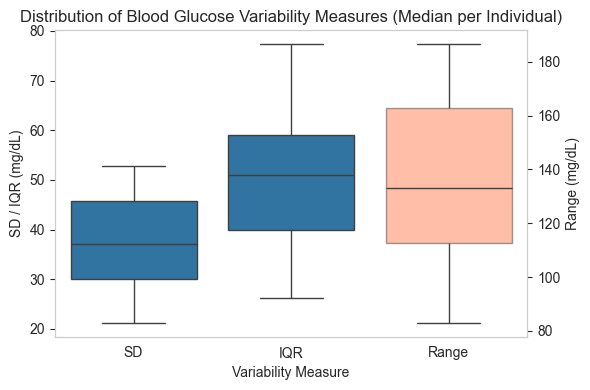

In [203]:
def filter_separated(separated_df, zip_ids):
    return [p for p in separated_df if p[0] in zip_ids]

bg_analysis = BGAnalyser(separated_dfs=filter_separated(separated, df_stats.index), night_start=night_start, morning_end=morning_end, sample_rate=sample_rate)

bg_analysis.plot_bg_variability()


In [204]:
cols = ['bg_sd_median', 'bg_range_median', 'bg_iqr_median']
calculate_skew_kurtosis(df_stats, cols)

,Skewness,Kurtosis
bg_sd_median,0.045982,-1.035030
bg_range_median,0.017911,-1.217644
bg_iqr_median,0.196868,-0.554123


All negative valuess for kurtosis indicate that the distributions are platykurtic, meaning they have lighter tails than a normal distribution. The skewness values are all close to zero, indicating that the distributions are fairly symmetric. This suggests that the variability measures are not heavily influenced by extreme values and are relatively consistent across individuals.

Note that this is across the whole timeframe of the period. This will take into account the last meal and BG spike following this. If we limit the hours to between 22:00 and 06:00, this will focus better on the variability during the sleep period, even though the times are arbitrary and do not take into account the individual sleep patterns or chronotype. Lets look at this data and distribution.


In [205]:
night_start = time(22, 0)
morning_end = time(6, 0)

df_overall_stats = get_all_individuals_night_stats(separated, sample_rate=sample_rate, night_start=night_start, morning_end=morning_end)

No stats per night have been calculated for 15634563. Returning no output.
No stats per night have been calculated for 49796612. Returning no output.
No stats per night have been calculated for 67167655. Returning no output.


In [206]:
print('Single interval missing constraint applied, i.e. complete nights and single interval missing')
df_overall_stats['useful_nights'] = df_overall_stats['complete_nights'] + df_overall_stats['single_interval_nights']
df_stats = df_overall_stats[['count_of_nights', 'useful_nights']+cols]
df_stats = df_stats[df_stats['useful_nights'] >= 30]
print(f'Total number of individuals with 30 or more useful nights: {len(df_stats)}')
print(f'Total number of nights across these individuals: {df_stats["useful_nights"].sum()}')

Single interval missing constraint applied, i.e. complete nights and single interval missing
Total number of individuals with 30 or more useful nights: 40
Total number of nights across these individuals: 3087


In [207]:
print('\nComplete nights constraint applied, i.e. not single interval missing')
df_stats = df_overall_stats[['count_of_nights', 'complete_nights']+cols]
df_stats = df_stats[df_stats['complete_nights'] >= 30]
print(f'Total number of individuals with 30 or more useful nights: {len(df_stats)}')
print(f'Total number of nights across these individuals: {df_stats["complete_nights"].sum()}')


Complete nights constraint applied, i.e. not single interval missing
Total number of individuals with 30 or more useful nights: 28
Total number of nights across these individuals: 1795


Without limiting to the existing candidates - i.e. using only the constaint of 30 or more nights and allowing for a single_interval_missed as well as complete nights - we can see that the number of individuals and nights and periods is much higher. This is because the constraints of the candidates are not applied, so we can see the variability across all individuals. If we do the same but limiting to complete nights...

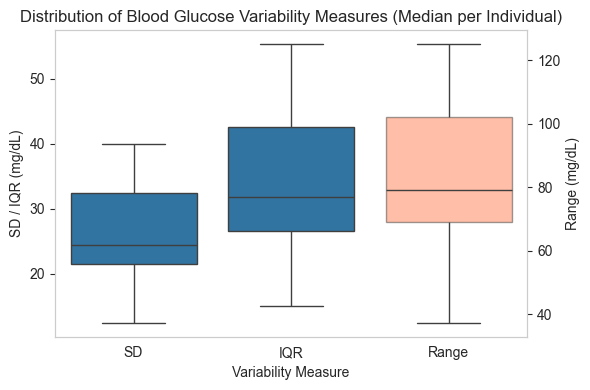

,Skewness,Kurtosis
bg_sd_median,0.354790,-0.589486
bg_range_median,0.182933,-0.356620
bg_iqr_median,0.450384,-0.550974


In [208]:
bg_analysis = BGAnalyser(separated_dfs=filter_separated(separated, df_stats.index), night_start=night_start, morning_end=morning_end, sample_rate=sample_rate)
bg_analysis.plot_bg_variability()
calculate_skew_kurtosis(df_stats, cols)

These show more skew to the lower to the minimal values, with the IQR and SD being more platykurtic. The range is more normal, but still has a slight skew to the lower values. This suggests that the variability measures are more consistent over this more bound time period. The variance is more muted than the 17:00-11:00 period as expected, given the lack of meals and the more stable blood glucose levels during the night. We now want to take a different perspective on the variability, considering how we might identify groups of nights that appear anomalous for an individual. To do this, we will use the z-score to identify nights that are more than 2 standard deviations away from the mean for an individual. This can help identify nights that are significantly different from the individual's 'normal' blood glucose patterns. The z-score allows us to standardise the blood glucose levels for each individual, making it easier to compare nights across individuals. We will then plot the z-scores for each individual and possibly compare them to other individuals with different distributions, to see if there are any patterns or similarities in the blood glucose levels across them. The z-score is calculated as follows:
$$ z = \frac{(x - \mu)}{\sigma} $$

where:
- $x$ is the blood glucose level for a specific night
- $\mu$ is the mean blood glucose level for the individual
- $\sigma$ is the standard deviation of the blood glucose levels for the individual
- $z$ is the z-score for the blood glucose level


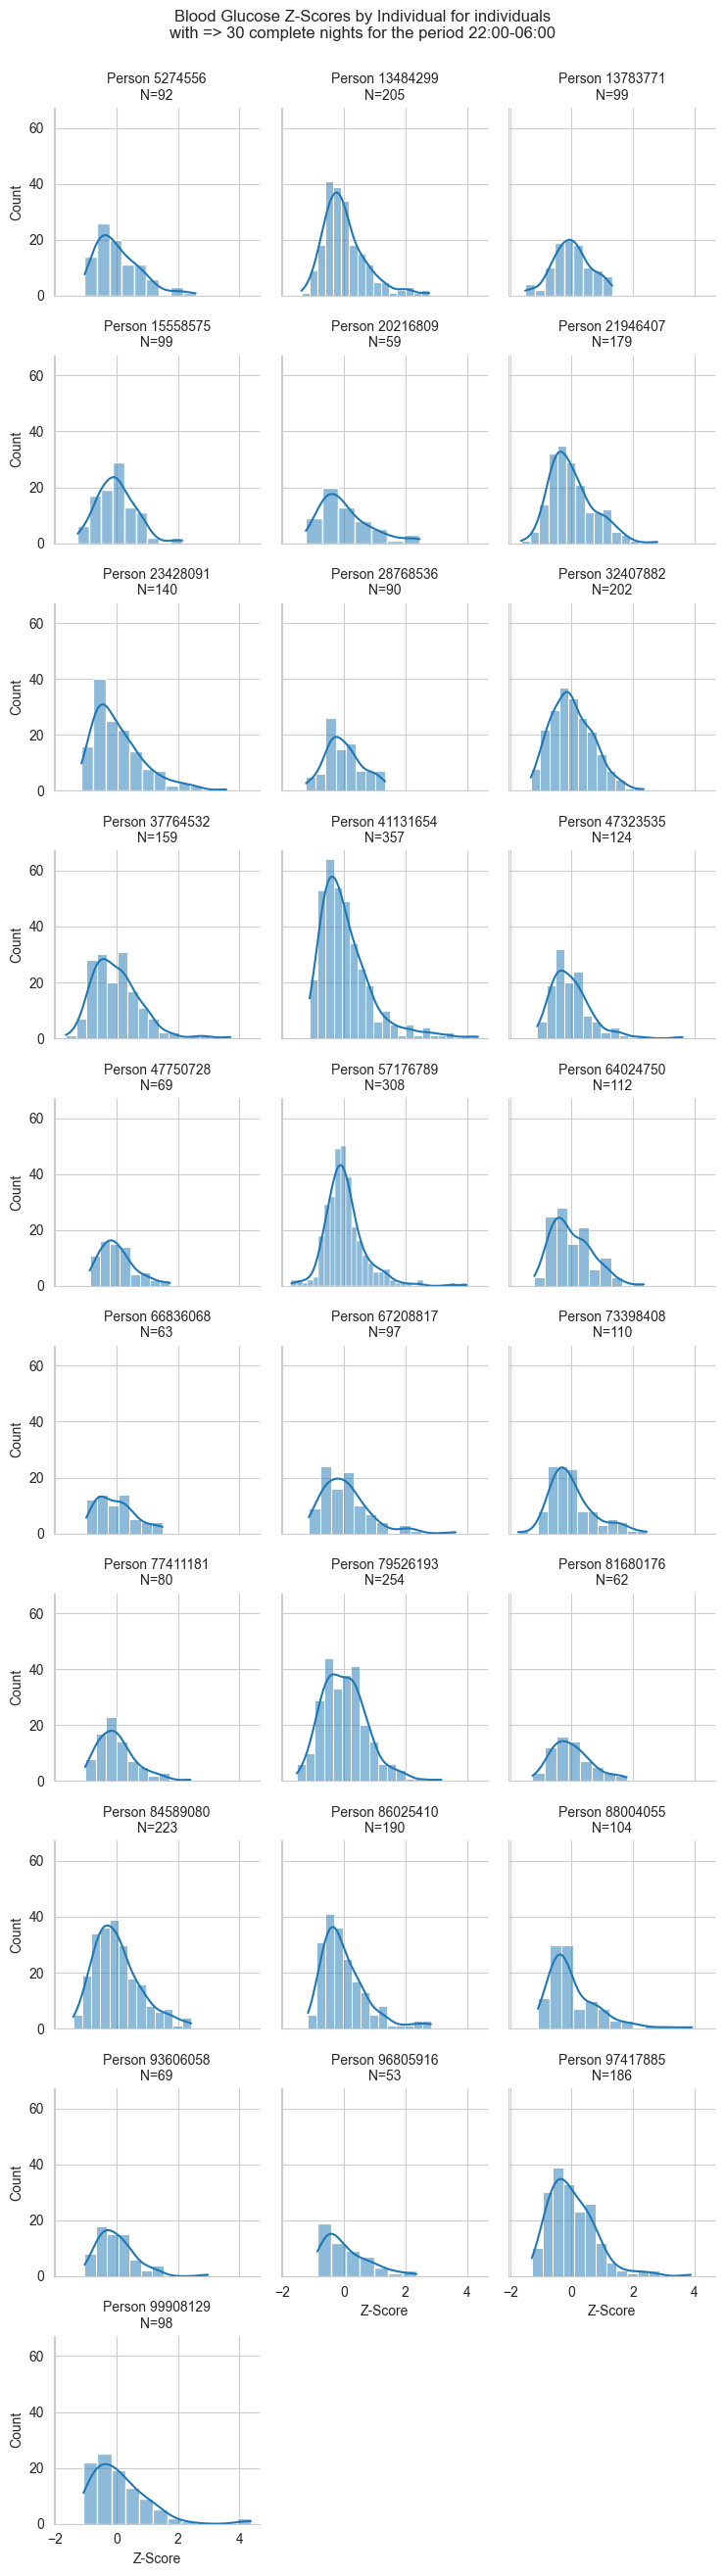

In [209]:
bg_analysis.plot_z_scores_per_individual()

Means for z-scores are showing values close to zero and with a skew to less than zero, sometimes with long tails in the positive direction, supporting the general view of the population in the boxplot above. This suggests that the blood glucose levels for these individuals are generally stable, with occasional spikes or drops that are not typical for them. The z-scores can help identify nights where the blood glucose levels were significantly different from the individual's normal patterns, which can be useful for further analysis or investigation. This can be done by looking at the nights with z-scores greater than 2 or less than -2, which would indicate nights where the blood glucose levels were significantly higher or lower than the individual's normal patterns. Given we are not seeing z-scores less than -2, we can focus on the positive z-scores. Collect night dates that have a >2 z-score and plot these nights may show if there are any patterns or similarities in the blood glucose levels across them.

28 individuals, have 3883 nights with z-scores > 2


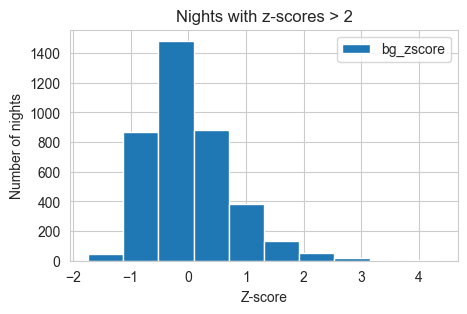

In [210]:
zscores = bg_analysis._return_z_scores()
zscores['outlier'] = zscores['bg_zscore'] > 2

print(f'{len(zscores["zip_id"].unique())} individuals, have {len(zscores)} nights with z-scores > 2')
zscores.plot(kind='hist', x='zip_id', figsize=(5, 3), title='Nights with z-scores > 2')
plt.ylabel('Number of nights')
plt.xlabel('Z-score')
plt.show()

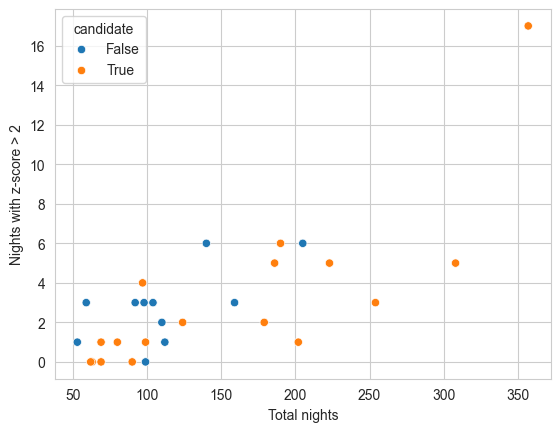

In [211]:
outlier_count_df = (zscores.groupby(['zip_id',]).
                    agg({'night_date':'count', 'outlier': 'sum'}).
                    reset_index())
outlier_count_df['candidate'] = outlier_count_df['zip_id'].apply(lambda x: x in candidates)
fig, ax = plt.subplots()
sns.scatterplot(outlier_count_df, x='night_date', y='outlier',
                hue='candidate',
                ax=ax)
plt.ylabel('Nights with z-score > 2')
plt.yticks(range(0,len(candidates),2))
plt.xlabel('Total nights')
plt.show()

In [212]:
outlier_count_df

,zip_id,night_date,outlier,candidate
0,5274556,92,3,False
1,13484299,205,6,False
2,13783771,99,0,False
3,15558575,99,1,True
4,20216809,59,3,False
5,21946407,179,2,True
6,23428091,140,6,False
7,28768536,90,0,True
8,32407882,202,1,True
9,37764532,159,3,False


In [214]:
nights.nights[0]

(datetime.date(2017, 9, 18),
                      iob mean  cob mean     bg mean  iob min  cob min  bg min  \
 datetime                                                                        
 2017-09-18 22:00:00      0.77       0.0      105.25    0.445      0.0   101.0   
 2017-09-18 22:30:00     0.751       0.0       111.0    0.751      0.0   111.0   
 2017-09-18 23:00:00     1.498       0.0  127.400002    1.447      0.0   125.0   
 2017-09-18 23:30:00     1.269       0.0     122.333    1.157      0.0   120.0   
 2017-09-19 00:00:00     0.927       0.0     112.667    0.752      0.0   108.0   
 2017-09-19 00:30:00     0.557       0.0       105.0    0.475      0.0   103.0   
 2017-09-19 04:30:00     0.002     120.0       118.0    0.002    120.0   118.0   
 2017-09-19 05:00:00     1.777     120.0       174.0    1.777    120.0   174.0   
 2017-09-19 05:30:00     4.887     120.0       202.0    4.735    120.0   201.0   
 
                      iob max  cob max  bg max  iob std  cob std  b